In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.metrics import normalized_mutual_info_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
price = pd.read_csv('price_demand_data.csv')
price.head()

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICECATEGORY
0,VIC1,1/01/2021 0:30,4179.21,LOW
1,VIC1,1/01/2021 1:00,4047.76,LOW
2,VIC1,1/01/2021 1:30,3934.70,LOW
3,VIC1,1/01/2021 2:00,3766.45,LOW
4,VIC1,1/01/2021 2:30,3590.37,LOW


##### We need to summarize data as we don’t need to know the demands for different hours in a day. So we clean all the hours from SETTLEMENT column

In [3]:
price['SETTLEMENTDATE'] = price['SETTLEMENTDATE'].str.rstrip(':0123456789')
price['SETTLEMENTDATE'] = price['SETTLEMENTDATE'].str.rstrip(' ')

##### Let's check what we have in REGION column? 

In [4]:
price['REGION'].describe()

count     11664
unique        1
top        VIC1
freq      11664
Name: REGION, dtype: object

##### All the data is for VIC1 so we drop REGION column.

##### We put Date as index in both DataFrame so we can merge them together later, before doing that we rename SETTLEMENTDATE to Date.

In [5]:
price = price.drop(['REGION'] , axis = 1)
price = price.rename(columns={'SETTLEMENTDATE': 'Date'})
price.set_index('Date')
price.head()

,Date,TOTALDEMAND,PRICECATEGORY
0,1/01/2021,4179.21,LOW
1,1/01/2021,4047.76,LOW
2,1/01/2021,3934.70,LOW
3,1/01/2021,3766.45,LOW
4,1/01/2021,3590.37,LOW


##### To find maximum daily price category, we replace 'LOW' to 1 , 'MEDIUM' to 2, 'HIGH' to 3 and 'EXTREME' to 4 to find maximum price category, then we will replace to original

In [6]:
price=price.replace(to_replace="LOW",value=1)

In [7]:
price=price.replace(to_replace="MEDIUM",value=2)

In [8]:
price=price.replace(to_replace="HIGH",value=3)

In [9]:
price=price.replace(to_replace="EXTREME",value=4)

In [10]:
price.head()

,Date,TOTALDEMAND,PRICECATEGORY
0,1/01/2021,4179.21,1
1,1/01/2021,4047.76,1
2,1/01/2021,3934.70,1
3,1/01/2021,3766.45,1
4,1/01/2021,3590.37,1


##### Now we groupby by date and aggregate as 'TOTALDEMAND': 'max' , 'PRICECATEGORY': 'max', we think that for total demand we should consider maximum demand not adding all the demand during everyday. We change name of TOTALDEMAND to Max_Demand

In [11]:

price1=price.groupby('Date').agg({'TOTALDEMAND': 'max' , 'PRICECATEGORY': 'max'})
price1 = price1.rename(columns={'TOTALDEMAND': 'Max_Demand'})

price1.head()

,Max_Demand,PRICECATEGORY
Date,,
1/01/2021,5019.64,1
1/02/2021,5228.29,2
1/03/2021,5225.37,1
1/04/2021,5807.02,2
1/05/2021,5261.09,2


##### Now we change the values of 'PRICECATEGORY' to original ones:

In [12]:
price1=price1.replace(to_replace=1,value="LOW")

In [13]:
price1=price1.replace(to_replace=2,value="MEDIUM")

In [14]:
price1=price1.replace(to_replace=3,value="HIGH")

In [15]:
price1=price1.replace(to_replace=4,value="EXTREME")

In [16]:
price1.head()

,Max_Demand,PRICECATEGORY
Date,,
1/01/2021,5019.64,LOW
1/02/2021,5228.29,MEDIUM
1/03/2021,5225.37,LOW
1/04/2021,5807.02,MEDIUM
1/05/2021,5261.09,MEDIUM


##### Let's have a look at second DataFrame about weather:

In [17]:
weather = pd.read_csv('weather_data.csv')

In [18]:
weather.head()

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,1/01/2021,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,...,6,N,2,1018.8,28.1,43,5.0,E,13,1015.3
1,2/01/2021,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,...,7,NNW,17,1013.3,28.7,38,7.0,SW,4,1008.5
2,3/01/2021,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,...,8,WSW,4,1007.7,23.5,59,4.0,SSW,2,1005.2
3,4/01/2021,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,...,8,SSE,11,1010.0,18.2,82,8.0,SSW,17,1011.0
4,5/01/2021,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,...,8,SSE,13,1012.5,18.2,82,8.0,SSE,19,1013.3


##### We calculate Average temperature and Range per day and add to DataFrame:

In [19]:
weather['Average temperature (°C)'] = (weather['Minimum temperature (°C)'] + weather['Maximum temperature (°C)']) / 2
weather['Temperature range (°C)'] = weather['Maximum temperature (°C)'] - weather['Minimum temperature (°C)']

##### It looks some columns dosen't effect on electricity demand, so let's keep some which might be help us.

##### We put Date as index in both DataFrame so we can merge them together later.

In [21]:
weather = weather.set_index('Date')

In [22]:
weather.head()

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),9am relative humidity (%),...,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),Average temperature (°C),Temperature range (°C)
Date,,,,,,,,,,,,,,,,,,,,,
1/01/2021,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,77.0,...,2,1018.8,28.1,43,5.0,E,13,1015.3,22.75,14.3
2/01/2021,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,52.0,...,17,1013.3,28.7,38,7.0,SW,4,1008.5,23.70,10.6
3/01/2021,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,100.0,...,4,1007.7,23.5,59,4.0,SSW,2,1005.2,21.60,9.2
4/01/2021,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,98.0,...,11,1010.0,18.2,82,8.0,SSW,17,1011.0,17.30,2.6
5/01/2021,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,96.0,...,13,1012.5,18.2,82,8.0,SSE,19,1013.3,17.50,3.2


In [23]:
result = pd.merge(weather,price1, left_index=True,right_index=True, how='inner')

In [24]:
result

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),9am relative humidity (%),...,3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),Average temperature (°C),Temperature range (°C),Max_Demand,PRICECATEGORY
Date,,,,,,,,,,,,,,,,,,,,,
1/01/2021,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,77.0,...,28.1,43,5.0,E,13,1015.3,22.75,14.3,5019.64,LOW
2/01/2021,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,52.0,...,28.7,38,7.0,SW,4,1008.5,23.70,10.6,4964.35,LOW
3/01/2021,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,100.0,...,23.5,59,4.0,SSW,2,1005.2,21.60,9.2,4503.31,LOW
4/01/2021,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,98.0,...,18.2,82,8.0,SSW,17,1011.0,17.30,2.6,4764.18,LOW
5/01/2021,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,96.0,...,18.2,82,8.0,SSE,19,1013.3,17.50,3.2,4800.64,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27/08/2021,4.6,13.6,0.0,1.2,3.8,SSW,15.0,12:18,7.7,88.0,...,12.8,65,7.0,SSE,7,1017.4,9.10,9.0,6769.89,EXTREME
28/08/2021,5.3,17.8,0.0,1.6,9.6,N,39.0,13:14,9.1,80.0,...,17.4,31,3.0,NNW,24,1013.5,11.55,12.5,5716.32,MEDIUM
29/08/2021,9.1,16.2,0.6,6.4,4.3,NNE,33.0,1:50,10.6,79.0,...,12.8,84,7.0,S,6,1010.4,12.65,7.1,6227.89,EXTREME


##### we can't calculate  mutual information if there are some NaN in DataFrame, so let's how many NaN values we have in our DataFrame.


In [25]:
result.isna().sum()

Minimum temperature (°C)             1
Maximum temperature (°C)             1
Rainfall (mm)                        2
Evaporation (mm)                     0
Sunshine (hours)                     0
Direction of maximum wind gust       3
Speed of maximum wind gust (km/h)    3
Time of maximum wind gust            3
9am Temperature (°C)                 1
9am relative humidity (%)            1
9am cloud amount (oktas)             0
9am wind direction                   1
9am wind speed (km/h)                1
9am MSL pressure (hPa)               2
3pm Temperature (°C)                 0
3pm relative humidity (%)            0
3pm cloud amount (oktas)             1
3pm wind direction                   0
3pm wind speed (km/h)                0
3pm MSL pressure (hPa)               1
Average temperature (°C)             1
Temperature range (°C)               1
Max_Demand                           0
PRICECATEGORY                        0
dtype: int64

##### Let's see how many NaN we have in all DataFrame.

In [26]:
result.loc[:].isna().sum().sum()

23

##### And how many rows have NaN. 

In [27]:
sum([True for idx,row in result.iterrows() if any(row.isnull())])

6

##### As we have just 6 rows which having NaN in 243 rows so we decided to drop these rows.

In [28]:
result=result.dropna(axis=0)

In [29]:
result

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),9am relative humidity (%),...,3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),Average temperature (°C),Temperature range (°C),Max_Demand,PRICECATEGORY
Date,,,,,,,,,,,,,,,,,,,,,
1/01/2021,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,77.0,...,28.1,43,5.0,E,13,1015.3,22.75,14.3,5019.64,LOW
2/01/2021,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,52.0,...,28.7,38,7.0,SW,4,1008.5,23.70,10.6,4964.35,LOW
3/01/2021,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,100.0,...,23.5,59,4.0,SSW,2,1005.2,21.60,9.2,4503.31,LOW
4/01/2021,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,98.0,...,18.2,82,8.0,SSW,17,1011.0,17.30,2.6,4764.18,LOW
5/01/2021,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,96.0,...,18.2,82,8.0,SSE,19,1013.3,17.50,3.2,4800.64,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26/08/2021,5.5,12.9,1.2,2.4,1.0,SE,31.0,12:54,9.2,82.0,...,12.2,55,7.0,SSE,13,1020.3,9.20,7.4,7126.76,EXTREME
27/08/2021,4.6,13.6,0.0,1.2,3.8,SSW,15.0,12:18,7.7,88.0,...,12.8,65,7.0,SSE,7,1017.4,9.10,9.0,6769.89,EXTREME
28/08/2021,5.3,17.8,0.0,1.6,9.6,N,39.0,13:14,9.1,80.0,...,17.4,31,3.0,NNW,24,1013.5,11.55,12.5,5716.32,MEDIUM


##### Let's check data type in each column and then if it is continues we can run scatter plot and corrolation to see if there is any relationship between independant variables and Max_Demand as dependant variable.

In [30]:
print(result.dtypes)

Minimum temperature (°C)             float64
Maximum temperature (°C)             float64
Rainfall (mm)                        float64
Evaporation (mm)                     float64
Sunshine (hours)                     float64
Direction of maximum wind gust        object
Speed of maximum wind gust (km/h)    float64
Time of maximum wind gust             object
9am Temperature (°C)                 float64
9am relative humidity (%)            float64
9am cloud amount (oktas)               int64
9am wind direction                    object
9am wind speed (km/h)                 object
9am MSL pressure (hPa)               float64
3pm Temperature (°C)                 float64
3pm relative humidity (%)              int64
3pm cloud amount (oktas)             float64
3pm wind direction                    object
3pm wind speed (km/h)                 object
3pm MSL pressure (hPa)               float64
Average temperature (°C)             float64
Temperature range (°C)               float64
Max_Demand

##### for all columns with continues data (float and integer) we use scatter plot and pearson corrolation:

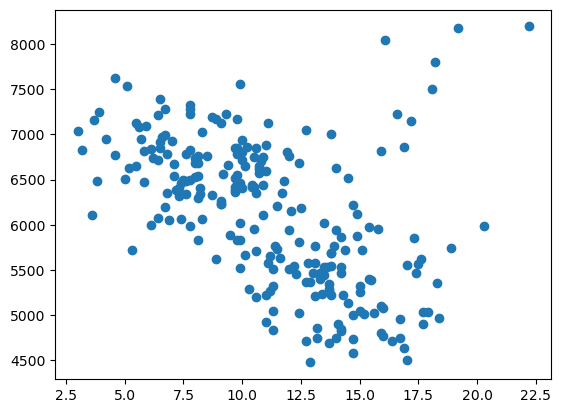

Pearson r for Minimum temperature (°C) and Max_Demand is  -0.4829170321902499


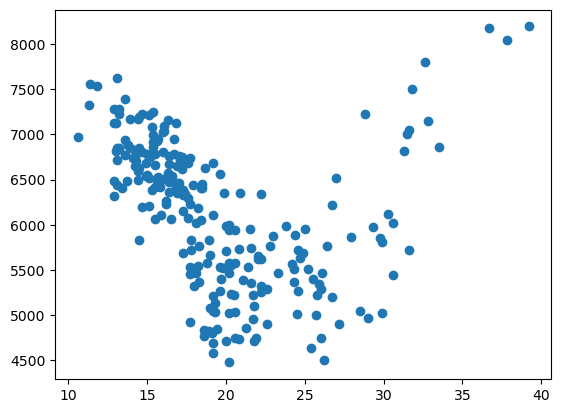

Pearson r for Maximum temperature (°C) and Max_Demand is  -0.2787024324856696


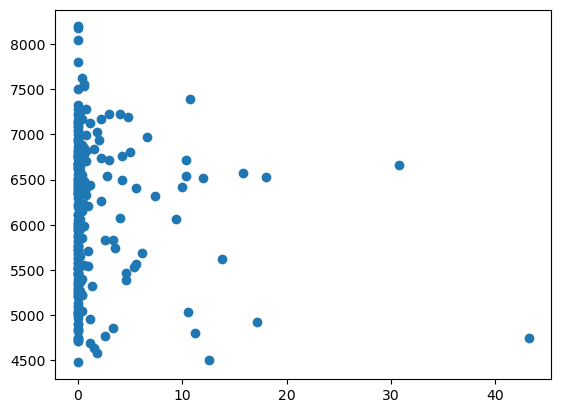

Pearson r for Rainfall (mm) and Max_Demand is  -0.0701800503023311


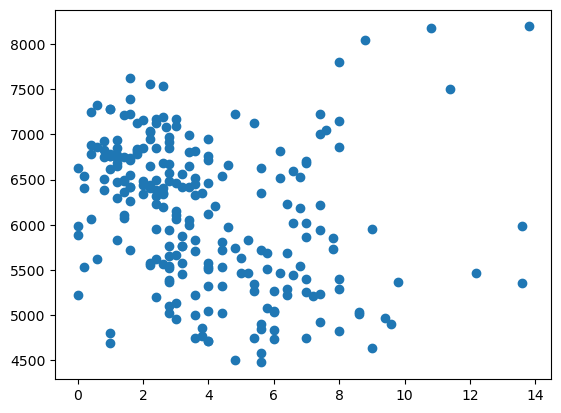

Pearson r for Evaporation (mm) and Max_Demand is  -0.24058345179672


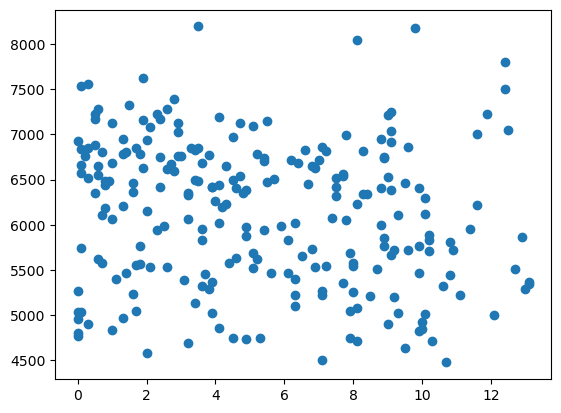

Pearson r for Sunshine (hours) and Max_Demand is  -0.1615137770463744


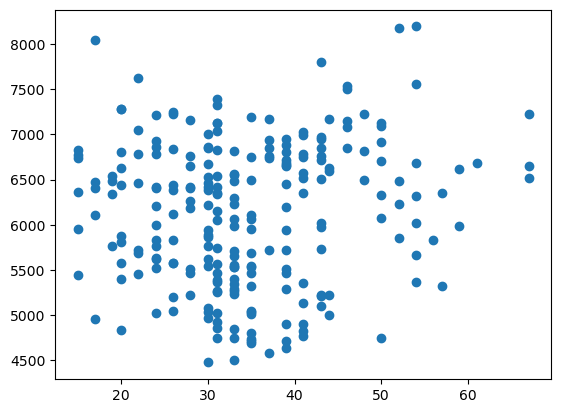

Pearson r for Speed of maximum wind gust (km/h) and Max_Demand is  0.10915564884517165


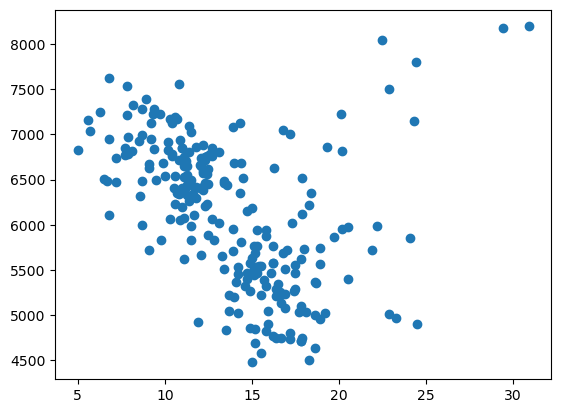

Pearson r for 9am Temperature (°C) and Max_Demand is  -0.375774499573087


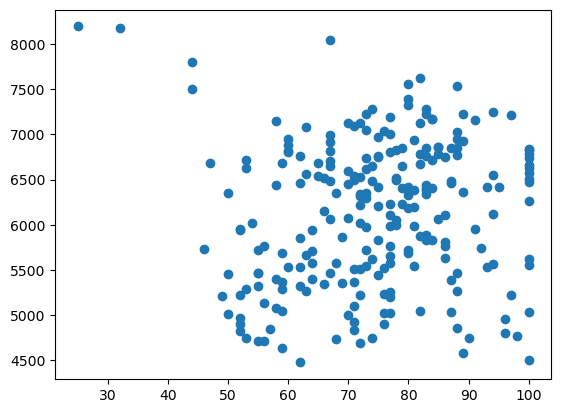

Pearson r for 9am relative humidity (%) and Max_Demand is  0.08601816151768922


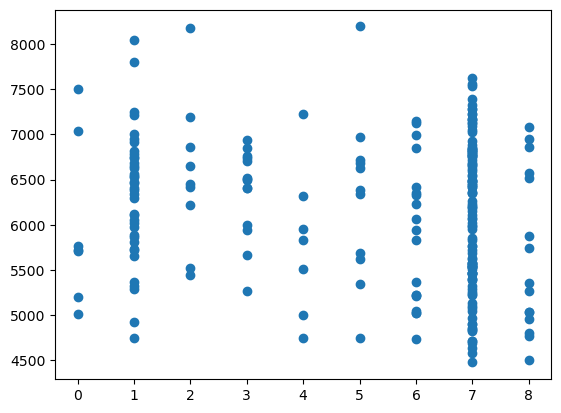

Pearson r for 9am cloud amount (oktas) and Max_Demand is  -0.14985141491960405


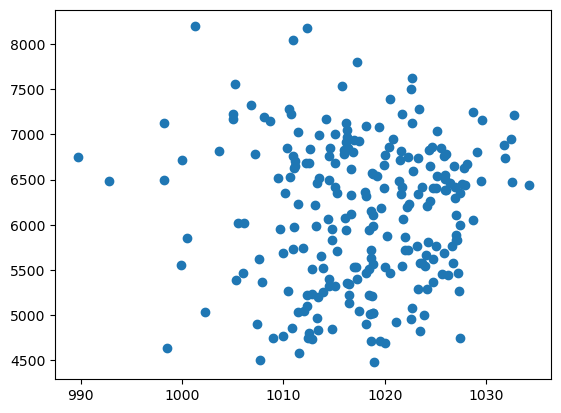

Pearson r for 9am MSL pressure (hPa) and Max_Demand is  0.03649754316524864


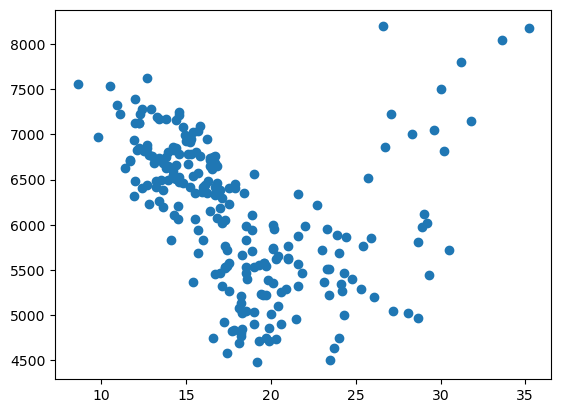

Pearson r for 3pm Temperature (°C) and Max_Demand is  -0.30701246985285396


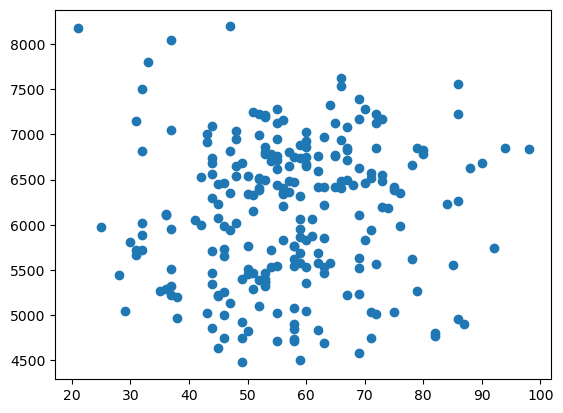

Pearson r for 3pm relative humidity (%) and Max_Demand is  0.0645719580361232


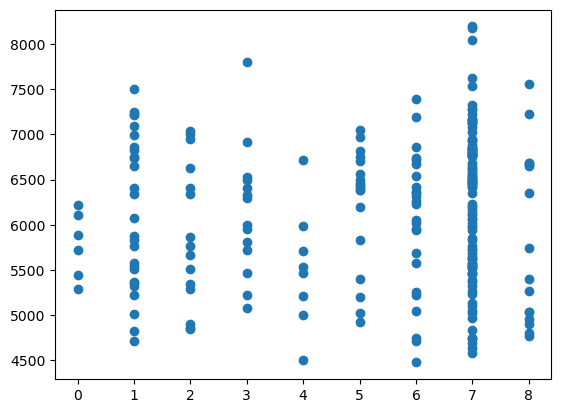

Pearson r for 3pm cloud amount (oktas) and Max_Demand is  0.0832328767887722


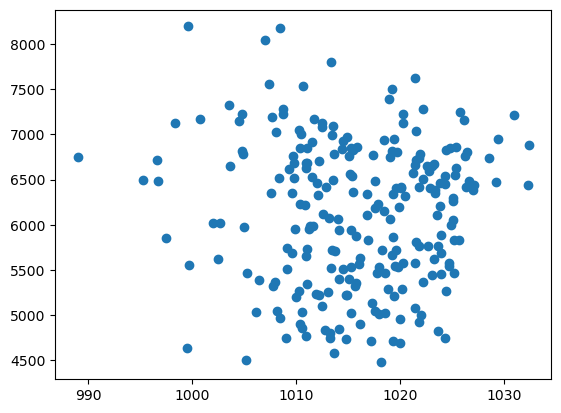

Pearson r for 3pm MSL pressure (hPa) and Max_Demand is  -0.018737272238024932


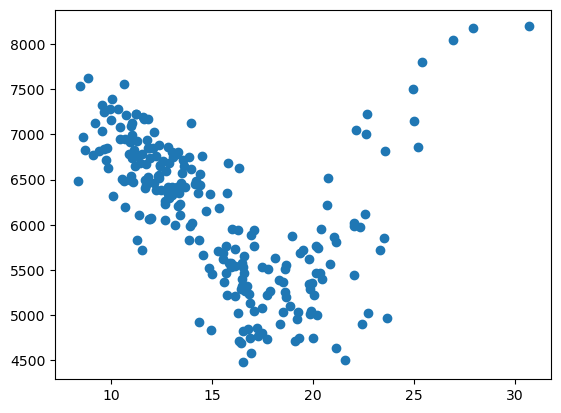

Pearson r for Average temperature (°C) and Max_Demand is  -0.39282894985092165


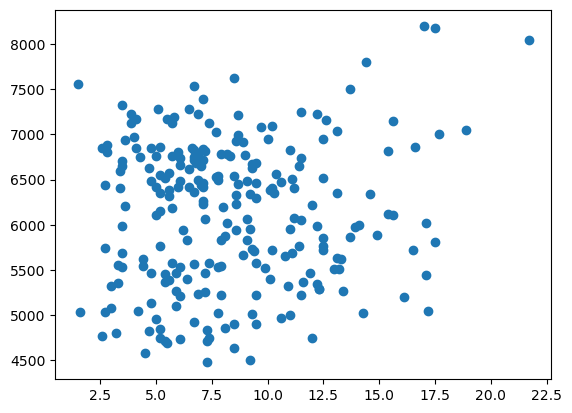

Pearson r for Temperature range (°C) and Max_Demand is  0.0902858492620293


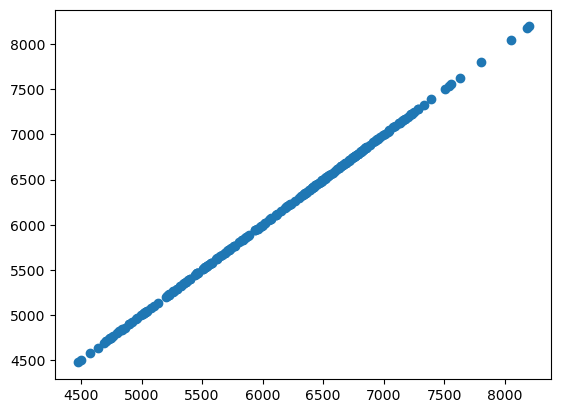

Pearson r for Max_Demand and Max_Demand is  1.0


In [31]:
for column in result:
    if result[column].dtypes == 'float64' or result[column].dtypes == 'int64' :
        plt.scatter(result[f'{column}'],result['Max_Demand'])
        plt.show()

        print(f"Pearson r for {column} and Max_Demand is ",result[f'{column}'].corr(result['Max_Demand']))

##### As we investigate the scatter graphs we find out  there is relation between temperature and demand. to not putting too much weight on temperature we used Average temperature for our model, before decide about our model let's have a look at scatter graph:

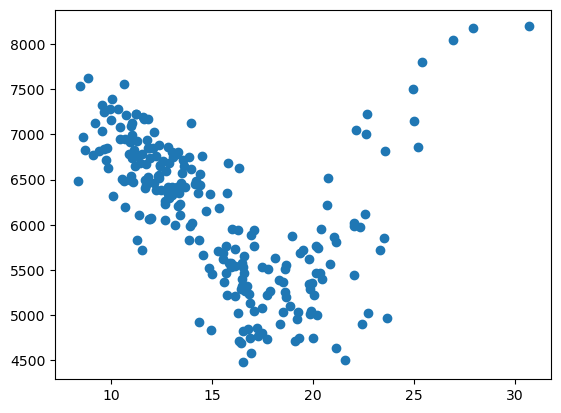

In [32]:
plt.scatter(result['Average temperature (°C)'],result['Max_Demand'])
plt.show()

In [33]:
result['Average temperature (°C)'].max()

30.700000000000003

In [34]:
result['Average temperature (°C)'].min()

8.35

##### As we see in the scatter there is a kind of parabola. We can define a temperature where is about minimum demand and have two model.
##### when we look at scatter it looks 18 degree is a proper point, so we will have two model for temperature in range [8,19] and (19,30]

In [35]:
result1 = result.loc[result['Average temperature (°C)'] <= 19]
result1.head()

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),9am relative humidity (%),...,3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),Average temperature (°C),Temperature range (°C),Max_Demand,PRICECATEGORY
Date,,,,,,,,,,,,,,,,,,,,,
4/01/2021,16.0,18.6,2.6,3.8,0.0,SSE,41.0,16:03,16.2,98.0,...,18.2,82,8.0,SSW,17,1011.0,17.30,2.6,4764.18,LOW
5/01/2021,15.9,19.1,11.2,1.0,0.0,SSE,35.0,11:02,17.2,96.0,...,18.2,82,8.0,SSE,19,1013.3,17.50,3.2,4800.64,LOW
6/01/2021,13.7,19.2,1.2,1.0,3.2,S,35.0,14:56,15.2,72.0,...,18.1,63,7.0,SSW,17,1020.0,16.45,5.5,4691.13,LOW
8/01/2021,12.7,24.3,0.0,9.8,13.1,SSW,31.0,15:04,18.6,59.0,...,23.1,53,1.0,SSW,11,1022.2,18.50,11.6,5365.19,MEDIUM
14/01/2021,15.0,22.2,0.0,7.0,8.0,W,31.0,23:23,16.6,77.0,...,20.6,46,6.0,SSW,9,1013.1,18.60,7.2,5257.95,MEDIUM


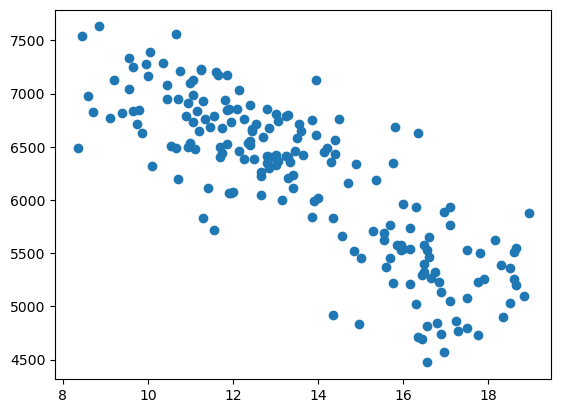

Pearson r is  -0.8296206327630037


In [36]:
plt.scatter(result1['Average temperature (°C)'],result1['Max_Demand'])
plt.show()

print("Pearson r is ",result1['Average temperature (°C)'].corr(result1['Max_Demand']))

##### That looks great when we split our model to two diffrent model we get -0.83 which is strongly linear. let's find our model for temperature in 
[ 8,19]

In [37]:
X = result1[['Average temperature (°C)']]
Y = result1['Max_Demand']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=1)

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

print(lm.coef_, lm.intercept_)
r2_test = lm.score(X_test, y_test)
print(r2_test)

[-252.4916575] 9679.692984636004
0.6515820021470787


# it looks we got a good r square. However if this model wants to be used for investing in power station need to study more. Our model will be y = 252.49 x +9679.69 but this model is for x in range [8,19]

##### let's check next model for temperature in range(19,30]

In [38]:
result2 = result.loc[result['Average temperature (°C)'] >= 19]
result2.head()

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),9am relative humidity (%),...,3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),Average temperature (°C),Temperature range (°C),Max_Demand,PRICECATEGORY
Date,,,,,,,,,,,,,,,,,,,,,
1/01/2021,15.6,29.9,0.0,2.8,9.3,NNE,31.0,13:14,19.2,77.0,...,28.1,43,5.0,E,13,1015.3,22.75,14.3,5019.64,LOW
2/01/2021,18.4,29.0,0.0,9.4,1.3,NNW,30.0,8:22,23.3,52.0,...,28.7,38,7.0,SW,4,1008.5,23.70,10.6,4964.35,LOW
3/01/2021,17.0,26.2,12.6,4.8,7.1,WSW,33.0,17:55,18.3,100.0,...,23.5,59,4.0,SSW,2,1005.2,21.60,9.2,4503.31,LOW
7/01/2021,14.7,25.7,0.0,3.6,12.1,SSE,44.0,13:21,18.6,70.0,...,24.3,46,4.0,SSE,20,1022.0,20.20,11.0,4994.78,LOW
9/01/2021,14.2,27.9,0.0,7.0,12.9,NNW,30.0,9:46,19.7,69.0,...,24.4,59,2.0,SSW,11,1019.3,21.05,13.7,5863.37,MEDIUM


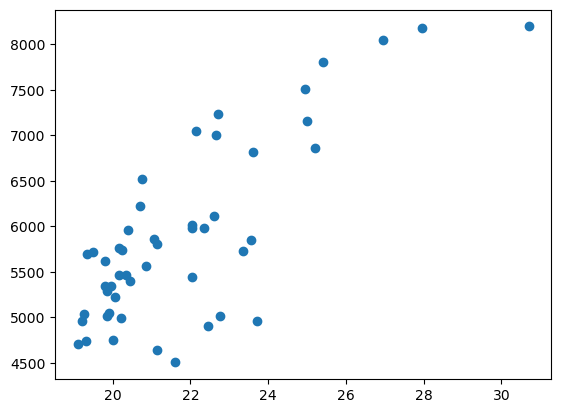

Pearson r is  0.78964135951396


In [39]:
plt.scatter(result2['Average temperature (°C)'],result2['Max_Demand'])
plt.show()

print("Pearson r is ",result2['Average temperature (°C)'].corr(result2['Max_Demand']))

##### It looks correlation is good lets define our second model: 

In [40]:
X = result2[['Average temperature (°C)']]
Y = result2['Max_Demand']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state=1)

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

print(lm.coef_, lm.intercept_)
r2_test = lm.score(X_test, y_test)
print(r2_test)

[265.47481699] 407.4653057659043
0.4846312686496236


##### second model looks not as good as the first one, That's why we wrote it in small font!!. But having r square about 0.5 is not too bad.Our model will be y = 265.47 x +407.46 but this model is for x in range [19,30]